# GRBM trained on a single subject

In [33]:
import numpy as np
from numpy.random import default_rng
from pydeep.rbm.model import GaussianBinaryRBM
import os
import os.path as op
import pandas as pd
from prob_models.utils.utils import read_paths, getdata
from pydeep.rbm.trainer import CD
from pydeep.rbm.estimator import (partition_function_factorize_h, 
                                  log_likelihood_v, 
                                  reconstruction_error,
                                  annealed_importance_sampling)

In [34]:
def split_train_test(X, train_fraction, standardize=False, shuffle=True, seed=None):
    rng = default_rng(seed)
    X = X.copy()
    if shuffle:
        rng.shuffle(X)
    T, N = X.shape
    Xtrain = X[:int(train_fraction*T)]
    Xtest = X[int(train_fraction*T):]
    if standardize:
        avg = np.mean(Xtrain, axis=0)
        Xtrain -= avg 
        std = np.std(Xtrain, axis=0)
        Xtrain /= std
        
        Xtest -= avg
        Xtest /= std


    return Xtrain, Xtest


def train_rbm(X_train, X_test, n_hid, epochs):
    n_v = X_train.shape[-1]
    variances = np.var(X_train, axis=0, keepdims=True)
    
    results = {}
    epoch_module = 20
    ll_trains = np.zeros((len(n_hid), int(epochs/epoch_module)+1))
    ll_tests = np.zeros((len(n_hid), int(epochs/epoch_module)+1))
    count = 0
    

    for n_h in n_hid:
        print(f'\nTraining with {n_h} hidden units')
        count += 1
        
        grbm = GaussianBinaryRBM(number_visibles=n_v,
                                number_hiddens=n_h,
                                data=X1_train,initial_sigma=variances,
                                initial_visible_offsets=0.0,
                                initial_hidden_offsets=0.0)
        trainer = CD(grbm)
        
        count_epoch = 0
        for epoch in range(epochs):
               
            trainer.train(data = X_train)
            
            if epoch % epoch_module == 0:
                
                count_epoch += 1 
                print(f'Epoch {epoch}')
                log_z = annealed_importance_sampling(grbm, status=False)
                ll_trains[count-1, count_epoch-1] = np.mean(log_likelihood_v(grbm, log_z, X_train))
                ll_tests[count-1, count_epoch-1] = np.mean(log_likelihood_v(grbm, log_z, X_test))
                print('ll_train is', ll_trains[count-1, count_epoch-1])
                print('ll_test is', ll_tests[count-1, count_epoch-1])
        
        ll_trains = np.array(ll_trains)
        ll_tests = np.array(ll_tests)
        print('Computing log-likelihood and reconstruction error...')
        # log_z = partition_function_factorize_h(grbm, status=False)
        log_z = annealed_importance_sampling(grbm, status=False)
        ll_train = np.mean(log_likelihood_v(grbm, log_z, X_train))
        ll_test = np.mean(log_likelihood_v(grbm, log_z, X_test))
        re = np.mean(reconstruction_error(grbm, X_train))
        print('...done')
        
        results[n_h] = {'ll_train': ll_train, 'll_test': ll_test, 're': re}
        
    results = pd.DataFrame.from_dict(results, orient='index')
    return results, ll_trains, ll_tests

In [35]:
# Load data 
paths = read_paths(op.join(os.getcwd(), op.join('..', '..', 'paths.txt')))
datadic = getdata(paths, dataset='CamCAN')

T, N = np.shape(list(datadic.values())[0])

tf = 0.8
X1 = datadic[1]

X1_train, X1_test = split_train_test(X1, train_fraction=tf, standardize=True, seed=0)
print(f'X1 shape: {X1_train.shape}')

n_hid = np.arange(2, 10, 3)
epochs = 100
results, ll_trains, ll_tests = train_rbm(X1_train, X1_test, n_hid, epochs)
print(results)


X1 shape: (208, 114)

Training with 2 hidden units
Epoch 0
ll_train is -162.47570629977477
ll_test is -181.98435865733762
Epoch 20
ll_train is -161.23027890062144
ll_test is -180.45654805892562
Epoch 40
ll_train is -158.72093823569452
ll_test is -177.2898306930831
Epoch 60
ll_train is -155.72865699261607
ll_test is -173.52489170340587
Epoch 80
ll_train is -153.16756689984496
ll_test is -170.25143226620676
Computing log-likelihood and reconstruction error...
...done

Training with 5 hidden units
Epoch 0
ll_train is -163.41681716707973
ll_test is -182.77095142192695
Epoch 20
ll_train is -159.0960723801704
ll_test is -177.18259054986277
Epoch 40
ll_train is -153.71008072405075
ll_test is -170.0869395101704
Epoch 60
ll_train is -150.43153339667285
ll_test is -165.4372664398253
Epoch 80
ll_train is -148.34264952279696
ll_test is -162.2942761142512
Computing log-likelihood and reconstruction error...
...done

Training with 8 hidden units
Epoch 0
ll_train is -164.41299659267315
ll_test is -18

In [36]:
import matplotlib.pyplot as plt

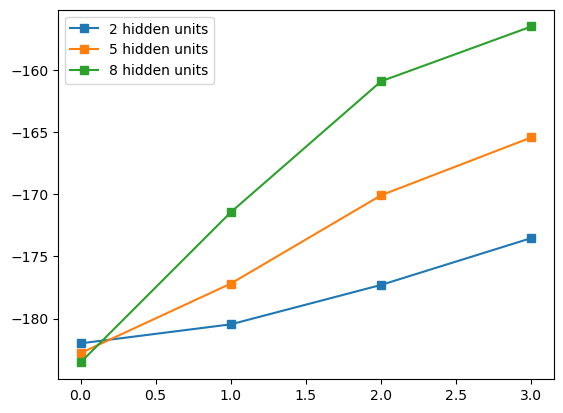

In [37]:
for el, h in zip(ll_tests, n_hid):
    plt.plot(el[:-2],'s-', label=f'{h} hidden units')
plt.legend()
plt.show()

In [38]:
np.shape(ll_tests)

(3, 6)

# GRBM trained on every subject in the dataset

In [107]:
def split_train_test(X, train_fraction, standardize=False, shuffle=True, 
                     seed=None):
    rng = default_rng(seed)
    X = X.copy()
    if shuffle:
        rng.shuffle(X)
    T, N = X.shape
    Xtrain = X[:int(train_fraction*T)]
    Xtest = X[int(train_fraction*T):]
    if standardize:
        avg = np.mean(Xtrain, axis=0)
        Xtrain -= avg 
        std = np.std(Xtrain, axis=0)
        Xtrain /= std
        
        Xtest -= avg
        Xtest /= std


    return Xtrain, Xtest


def train_rbm(X_train, X_test, n_hid, epochs, n_epochs=10):
    n_v = X_train.shape[-1]
    variances = np.var(X_train, axis=0, keepdims=True)
    
    ll_results, params = {}, {}
    ll_trains = np.zeros((len(n_hid), int(epochs/n_epochs)+1))
    ll_tests = np.zeros((len(n_hid), int(epochs/n_epochs)+1))
    std_trains = np.zeros((len(n_hid), int(epochs/n_epochs)+1))
    std_tests = np.zeros((len(n_hid), int(epochs/n_epochs)+1))
    count = 0 
    for n_h in n_hid:
        print(f'\nTraining with {n_h} hidden units')
        count += 1
        
        grbm = GaussianBinaryRBM(number_visibles=n_v,
                                number_hiddens=n_h,
                                data=X_train,
                                initial_sigma=variances,
                                initial_visible_offsets=0.0,
                                initial_hidden_offsets=0.0)
        trainer = CD(grbm)
        
        count_epoch = 0
        for epoch in range(epochs):
            
            trainer.train(data = X_train)
            
            if epoch % n_epochs == 0:
                count_epoch += 1    
                print(f'Epoch {epoch}')
                log_z = annealed_importance_sampling(grbm, status=False)
                ll_trains[count-1, count_epoch-1] = np.mean(log_likelihood_v(grbm, log_z, X_train))
                std_trains[count-1, count_epoch-1] = np.std(log_likelihood_v(grbm, log_z, X_train))
                ll_tests[count-1, count_epoch-1] = np.mean(log_likelihood_v(grbm, log_z, X_test))
                std_tests[count-1, count_epoch-1] = np.std(log_likelihood_v(grbm, log_z, X_test))
                print('ll_train is', ll_trains[count-1, count_epoch-1])
                print('ll_test is', ll_tests[count-1, count_epoch-1])
        
        ll_trains = np.array(ll_trains)
        ll_tests = np.array(ll_tests)
        print('Computing log-likelihood and reconstruction error...')
        # log_z = partition_function_factorize_h(grbm, status=True)
        log_z = annealed_importance_sampling(grbm, status=False)
        ll_train = np.mean(log_likelihood_v(grbm, log_z, X_train))
        ll_test = np.mean(log_likelihood_v(grbm, log_z, X_test))
        re = np.mean(reconstruction_error(grbm, X_train))
        print('...done')
        
        ll_results[n_h] = {'ll_train': ll_trains, 'll_test': ll_tests, 're': re, 'std_train': std_trains, 'std_test': std_tests}
        params[n_h] = grbm.get_parameters()[0]
        
    ll_results = pd.DataFrame.from_dict(ll_results, orient='index')
    return ll_results, params


In [ ]:
# Load data 
paths = read_paths(op.join(os.getcwd(), op.join('..', '..', 'paths.txt')))
# paths = read_paths('/home/jerry/python_projects/other/prob-models/paths.txt')
datadic = getdata(paths, dataset='CamCAN')
T, N = np.shape(list(datadic.values())[0])

tf = 0.8
# X1 = datadic[1]
X_train, X_test = [], []
for x in datadic.values():
    _X_train, _X_test = split_train_test(x, train_fraction=tf, 
                                            standardize=True, seed=None)
    X_train.append(_X_train)
    X_test.append(_X_test)
    
X_train = np.concatenate(X_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
    
print(f'Traininig set shape: {X_train.shape}')




### test sul numero di epoche fatto con 2 hidden units

In [ ]:
# n_hid = np.arange(2, 100, 10)
# n_hid = [2, 5, 10, 20, 50, 100]
n_hid = [2]
epochs = 1000
results, paramas = train_rbm(X_train, X_test, n_hid, epochs, n_epochs=50)
print(results)
print(paramas)

dirpath = op.join(os.getcwd(), 'results')
if not op.exists(dirpath):
    os.makedirs(dirpath)
results.to_csv(op.join(dirpath, 'results.csv'))
for n_h, p in paramas.items():
    np.save(op.join(dirpath, f'params_{n_h}.npy'), p)

### test sul numero di epoche con 80 hidden units

In [ ]:
# n_hid = np.arange(2, 100, 10)
# n_hid = [2, 5, 10, 20, 50, 100]
n_hid = [80]
epochs = 1000
results2, paramas2 = train_rbm(X_train, X_test, n_hid, epochs, n_epochs=50)
print(results2)
print(paramas2)

dirpath = op.join(os.getcwd(), 'results2')
if not op.exists(dirpath):
    os.makedirs(dirpath)
results2.to_csv(op.join(dirpath, 'results2.csv'))
for n_h, p in paramas2.items():
    np.save(op.join(dirpath, f'params2_{n_h}.npy'), p)


Training with 80 hidden units
Epoch 0
ll_train is -173.4530938184747
ll_test is -174.40009740592475
Epoch 50
ll_train is -145.11453503115757
ll_test is -145.5989565518134
Epoch 100
ll_train is -143.04289012070097
ll_test is -143.49915064614774
Epoch 150
ll_train is -141.54996567873206
ll_test is -141.98150666190512
Epoch 200
ll_train is -140.48574161648412
ll_test is -140.89981298230305
Epoch 250
ll_train is -139.7778236728761
ll_test is -140.18054331074808
Epoch 300
ll_train is -139.24998780032044
ll_test is -139.64531643889202
Epoch 350
ll_train is -138.85456226699503
ll_test is -139.24550299204057
Epoch 400
ll_train is -138.6193337541948
ll_test is -139.00752897885636
Epoch 450
ll_train is -138.32400629025202
ll_test is -138.71066208074333
Epoch 500
ll_train is -138.14831910633782
ll_test is -138.5338438082226
Epoch 550
ll_train is -138.01024608186373
ll_test is -138.3950531367434
Epoch 600
ll_train is -137.8315754245838
ll_test is -138.21596702706765
Epoch 650
ll_train is -137.760

### test con 25 hidden

In [ ]:
# n_hid = np.arange(2, 100, 10)
# n_hid = [2, 5, 10, 20, 50, 100]
n_hid = [25]
epochs = 1000
results3, paramas3 = train_rbm(X_train, X_test, n_hid, epochs, n_epochs=50)
print(results3)
print(paramas3)

dirpath = op.join(os.getcwd(), 'results3')
if not op.exists(dirpath):
    os.makedirs(dirpath)
results3.to_csv(op.join(dirpath, 'results3.csv'))
for n_h, p in paramas3.items():
    np.save(op.join(dirpath, f'params3_{n_h}.npy'), p)


Training with 25 hidden units
Epoch 0
ll_train is -168.15598815001678
ll_test is -169.18362713419683
Epoch 50
ll_train is -145.2277709671341
ll_test is -145.84580565193164
Epoch 100
ll_train is -145.00140084475348
ll_test is -145.57368903164286
Epoch 150
ll_train is -144.5212231118451
ll_test is -145.08434837368753
Epoch 200
ll_train is -144.04815439187573
ll_test is -144.60167892296047
Epoch 250
ll_train is -143.53495307728298
ll_test is -144.0786480768084
Epoch 300
ll_train is -143.19196461705403
ll_test is -143.72679489172396
Epoch 350
ll_train is -142.8449960975558
ll_test is -143.37230079809785
Epoch 400
ll_train is -142.51026002475
ll_test is -143.03110227249326
Epoch 450
ll_train is -142.1930595360337
ll_test is -142.70790274674005
Epoch 500
ll_train is -142.01671524154665
ll_test is -142.52575749552423
Epoch 550
ll_train is -141.72204200108263
ll_test is -142.22538554130094
Epoch 600
ll_train is -141.51412363758305
ll_test is -142.0119329118955
Epoch 650
ll_train is -141.37021

### plot finali

In [89]:
ll_test = results['ll_test'].values[0].flatten()
ll_train = results['ll_train'].values[0].flatten()
n_epochs = np.arange(0, epochs, 50)

ll_test2 = results2['ll_test'].values[0].flatten()
ll_train2 = results2['ll_train'].values[0].flatten()

ll_test3 = results3['ll_test'].values[0].flatten()
ll_train3 = results3['ll_train'].values[0].flatten()

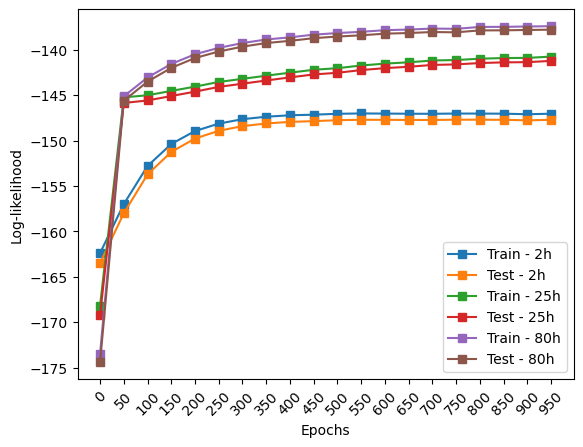

<Figure size 640x480 with 0 Axes>

In [90]:
plt.plot(n_epochs, ll_train[:-1], 's-', label='Train - 2h')
plt.plot(n_epochs, ll_test[:-1], 's-', label='Test - 2h')
plt.plot(n_epochs, ll_train3[:-1], 's-', label='Train - 25h')
plt.plot(n_epochs, ll_test3[:-1], 's-', label='Test - 25h')
plt.plot(n_epochs, ll_train2[:-1], 's-', label='Train - 80h')
plt.plot(n_epochs, ll_test2[:-1], 's-', label='Test - 80h')

plt.xticks(n_epochs, rotation=45)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log-likelihood')


plt.show()

plt.savefig('ll.png')

# test su RGBM trainata su un soggetto alla volta

In [103]:
# define the dataset
tf = 0.8
X1 = datadic[3]

X_train, X_test = split_train_test(X1, train_fraction=tf, 
                                        standardize=True, seed=None)

print(f'Traininig set shape: {X_train.shape}', 
        f'Test set shape: {X_test.shape}')


Traininig set shape: (208, 114) Test set shape: (53, 114)


In [116]:
# n_hid = np.arange(2, 100, 10)
# n_hid = [2, 5, 10, 20, 50]
n_hid = [50]
epochs = 1000
results1s, paramas1s = train_rbm(X_train, X_test, n_hid, epochs, n_epochs=50)
print(results1s)
print(paramas1s)

dirpath = op.join(os.getcwd(), 'results1s')
if not op.exists(dirpath):
    os.makedirs(dirpath)
results1s.to_csv(op.join(dirpath, 'results1s.csv'))
for n_h, p in paramas1s.items():
    np.save(op.join(dirpath, f'params1s_{n_h}.npy'), p)


Training with 50 hidden units
Epoch 0
ll_train is -170.03375327010465
ll_test is -172.6953359531376
Epoch 50
ll_train is -138.88415083752648
ll_test is -137.33481718040053
Epoch 100
ll_train is -137.2837302990452
ll_test is -136.48532824605292
Epoch 150
ll_train is -136.08345868762282
ll_test is -135.9883367140217
Epoch 200
ll_train is -135.54289547677254
ll_test is -135.7859065439074
Epoch 250
ll_train is -135.25753374289286
ll_test is -135.69943698957732
Epoch 300
ll_train is -135.1097021954561
ll_test is -135.7723605400876
Epoch 350
ll_train is -134.85184846071448
ll_test is -135.65608197237734
Epoch 400
ll_train is -134.57122880176783
ll_test is -135.47713979589997
Epoch 450
ll_train is -134.2200192896107
ll_test is -135.27513245558205
Epoch 500
ll_train is -133.93238805642955
ll_test is -135.08731840309954
Epoch 550
ll_train is -133.81280538734995
ll_test is -135.03828219299587
Epoch 600
ll_train is -133.48938660522984
ll_test is -134.83795867163093
Epoch 650
ll_train is -133.432

In [117]:
n_epochs = np.arange(0, epochs, 50)


ll_train1s = results1s['ll_train'].values[0].flatten()
std_train1s = results1s['std_train'].values[0].flatten()
ll_test1s = results1s['ll_test'].values[0].flatten()
std_test1s = results1s['std_test'].values[0].flatten()

'''
ll_test2 = results2['ll_test'].values[0].flatten()
ll_train2 = results2['ll_train'].values[0].flatten()

ll_test3 = results3['ll_test'].values[0].flatten()
ll_train3 = results3['ll_train'].values[0].flatten()
'''

"\nll_test2 = results2['ll_test'].values[0].flatten()\nll_train2 = results2['ll_train'].values[0].flatten()\n\nll_test3 = results3['ll_test'].values[0].flatten()\nll_train3 = results3['ll_train'].values[0].flatten()\n"

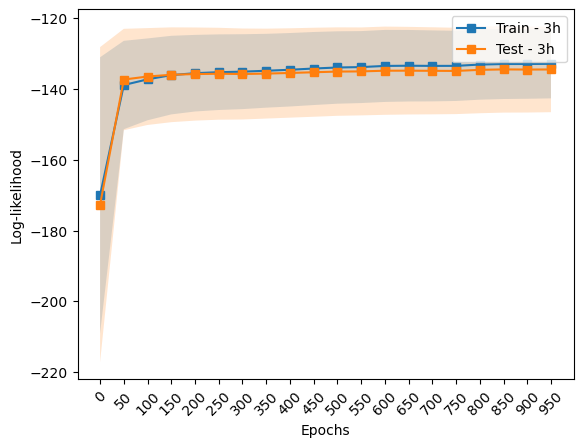

<Figure size 640x480 with 0 Axes>

In [118]:
plt.plot(n_epochs, ll_train1s[:-1], 's-', label='Train - 3h')
plt.plot(n_epochs, ll_test1s[:-1], 's-', label='Test - 3h')

plt.fill_between(n_epochs, ll_train1s[:-1] - std_train1s[:-1], ll_train1s[:-1] + std_train1s[:-1], alpha=0.2)
plt.fill_between(n_epochs, ll_test1s[:-1] - std_test1s[:-1], ll_test1s[:-1] + std_test1s[:-1], alpha=0.2)

plt.xticks(n_epochs, rotation=45)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log-likelihood')

plt.show()

plt.savefig('ll_train1s_with_std_band.png')

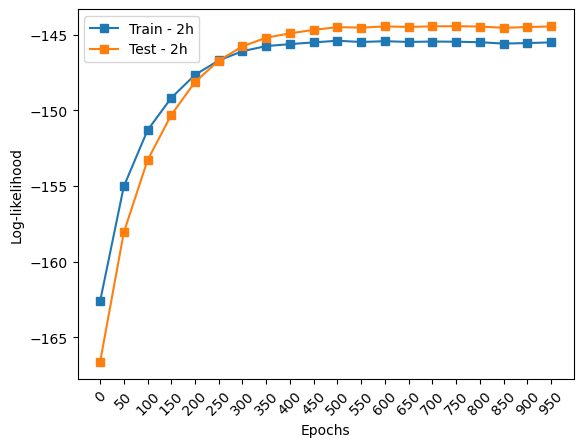

<Figure size 640x480 with 0 Axes>

In [110]:
plt.plot(n_epochs, ll_train1s[:-1], 's-', label='Train - 2h')
plt.plot(n_epochs, ll_test1s[:-1], 's-', label='Test - 2h')


plt.xticks(n_epochs, rotation=45)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log-likelihood')


plt.show()

plt.savefig('ll1s.png')

## test con grbm trainata su un soggetto alla volta, con vari n hidden

In [ ]:
# n_hid = np.arange(2, 100, 10)
n_hid = [2, 5, 10, 20, 50]
epochs = 500
results1s, paramas1s = train_rbm(X_train, X_test, n_hid, epochs, n_epochs=50)
print(results1s)
print(paramas1s)

dirpath = op.join(os.getcwd(), 'results1s')
if not op.exists(dirpath):
    os.makedirs(dirpath)
results1s.to_csv(op.join(dirpath, 'results1s.csv'))
for n_h, p in paramas1s.items():
    np.save(op.join(dirpath, f'params1s_{n_h}.npy'), p)

In [131]:
results1s

,ll_train,ll_test,re,std_train,std_test
2,"[[-161.96282000416556, -156.389241965783, -151...","[[-165.58890444390093, -158.7952512724384, -15...",0.626013,"[[42.59674787897465, 38.36145821494717, 33.864...","[[49.8925828795543, 46.37459084089353, 41.5604..."
5,"[[-161.96282000416556, -156.389241965783, -151...","[[-165.58890444390093, -158.7952512724384, -15...",0.591334,"[[42.59674787897465, 38.36145821494717, 33.864...","[[49.8925828795543, 46.37459084089353, 41.5604..."
10,"[[-161.96282000416556, -156.389241965783, -151...","[[-165.58890444390093, -158.7952512724384, -15...",0.489551,"[[42.59674787897465, 38.36145821494717, 33.864...","[[49.8925828795543, 46.37459084089353, 41.5604..."
20,"[[-161.96282000416556, -156.389241965783, -151...","[[-165.58890444390093, -158.7952512724384, -15...",0.420947,"[[42.59674787897465, 38.36145821494717, 33.864...","[[49.8925828795543, 46.37459084089353, 41.5604..."
50,"[[-161.96282000416556, -156.389241965783, -151...","[[-165.58890444390093, -158.7952512724384, -15...",0.291003,"[[42.59674787897465, 38.36145821494717, 33.864...","[[49.8925828795543, 46.37459084089353, 41.5604..."


In [148]:
ll_test1s = results1s.loc[50, 'll_test']
ll_train1s = results1s.loc[50, 'll_train']
std_test1s = results1s.loc[50, 'std_test']
std_train1s = results1s.loc[50, 'std_train']

In [152]:
ll_test1s[0, :-1]

array([-165.58890444, -158.79525127, -153.27569836, -149.19703531,
       -146.05557721, -144.12971925, -143.45496332, -143.51619137,
       -143.71199531, -143.87591466])

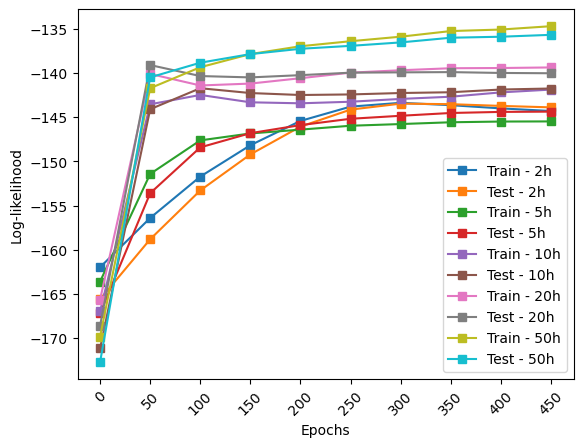

<Figure size 640x480 with 0 Axes>

In [156]:
plt.plot(n_epochs, ll_train1s[0, :-1], 's-', label='Train - 2h')
plt.plot(n_epochs, ll_test1s[0, :-1], 's-', label='Test - 2h')
plt.plot(n_epochs, ll_train1s[1, :-1], 's-', label='Train - 5h')
plt.plot(n_epochs, ll_test1s[1, :-1], 's-', label='Test - 5h')
plt.plot(n_epochs, ll_train1s[2, :-1], 's-', label='Train - 10h')
plt.plot(n_epochs, ll_test1s[2, :-1], 's-', label='Test - 10h')
plt.plot(n_epochs, ll_train1s[3, :-1], 's-', label='Train - 20h')
plt.plot(n_epochs, ll_test1s[3, :-1], 's-', label='Test - 20h')
plt.plot(n_epochs, ll_train1s[4, :-1], 's-', label='Train - 50h')
plt.plot(n_epochs, ll_test1s[4, :-1], 's-', label='Test - 50h')

#plt.fill_between(n_epochs, ll_train1s[0, :-1] - std_train1s[0,:-1], ll_train1s[0,:-1] + std_train1s[0,:-1], alpha=0.2)
#plt.fill_between(n_epochs, ll_test1s[0,:-1] - std_test1s[0,:-1], ll_test1s[0,:-1] + std_test1s[0,:-1], alpha=0.2)

plt.xticks(n_epochs, rotation=45)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Log-likelihood')

plt.show()

plt.savefig('ll_train1s_with_std_band.png')